In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# - !wget https://mirror.jframeworks.com/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!wget https://dlcdn.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
#    https://spark.apache.org/downloads.html -> click on Download Spark: spark-3.5.4-bin-hadoop3.tgz
!tar xvf spark-3.5.5-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark==3.5.5
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.5.5-bin-hadoop3"
#- Run the followings:

--2025-03-04 03:23:07--  https://dlcdn.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400724056 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.5-bin-hadoop3.tgz’

spark-3.5.5-bin-had 100%[===================>] 382.16M   192MB/s    in 2.0s    

2025-03-04 03:23:09 (192 MB/s) - ‘spark-3.5.5-bin-hadoop3.tgz’ saved [400724056/400724056]

spark-3.5.5-bin-hadoop3/
spark-3.5.5-bin-hadoop3/jars/
spark-3.5.5-bin-hadoop3/jars/HikariCP-2.5.1.jar
spark-3.5.5-bin-hadoop3/jars/JLargeArrays-1.5.jar
spark-3.5.5-bin-hadoop3/jars/JTransforms-3.1.jar
spark-3.5.5-bin-hadoop3/jars/RoaringBitmap-0.9.45.jar
spark-3.5.5-bin-hadoop3/jars/ST4-4.0.4.jar
spark-3.5.5-bin-hadoop3/jars/activation-1.1.1.jar
spark-3.5.5-bin-hadoop3/jars/aircompressor-0.27.jar
spark-3.5.5-bin-hadoop3/jars/alge

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('MLPRegressor').getOrCreate()

In [ ]:
# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","
file_type = "csv"

df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter).csv("/content/drive/MyDrive/HousingPriceRegression/data/kc_house_data_final.csv")

In [ ]:
df.show()
df.printSchema()

+----------+----+--------+---------+------------------+------------------+------+----------+----+---------+-----+-----------------+-------+-------+--------+-----------------+------------------+------------------+---------+----------------------+
|        id|date|bedrooms|bathrooms|       sqft_living|          sqft_lot|floors|waterfront|view|condition|grade|    sqft_basement|zipcode|    lat|    long|    sqft_living15|        sqft_lot15|             price|house_age|years_since_renovation|
+----------+----+--------+---------+------------------+------------------+------+----------+----+---------+-----+-----------------+-------+-------+--------+-----------------+------------------+------------------+---------+----------------------+
|7129300520|NULL|     3.0|      1.0| 7.074116816197362| 8.639587799629844|     1|         0|   0|        3|    7|             NULL|  98178|47.5112|-122.257|7.201170883281678| 8.639587799629844|12.309986615445005|       70|                  NULL|
|6414100192|NULL

In [ ]:
from pyspark.sql.functions import when, col

df = df.withColumn(
    "sqft_basement",
    when(col("sqft_basement").isNull(), 0)
    .otherwise(col("sqft_basement"))
)

df = df.withColumn(
    "years_since_renovation",
    when(col("years_since_renovation").isNull(), col("house_age"))
    .otherwise(col("years_since_renovation"))
)


In [ ]:
df = df.drop('id', 'date', 'lat', 'long')
df.printSchema()

root
 |-- bedrooms: string (nullable = true)
 |-- bathrooms: string (nullable = true)
 |-- sqft_living: string (nullable = true)
 |-- sqft_lot: string (nullable = true)
 |-- floors: string (nullable = true)
 |-- waterfront: string (nullable = true)
 |-- view: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sqft_basement: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- sqft_living15: string (nullable = true)
 |-- sqft_lot15: string (nullable = true)
 |-- price: string (nullable = true)
 |-- house_age: string (nullable = true)
 |-- years_since_renovation: string (nullable = true)



In [ ]:
df.show(10)

+--------+---------+-----------------+------------------+------+----------+----+---------+-----+-----------------+-------+-----------------+------------------+------------------+---------+----------------------+
|bedrooms|bathrooms|      sqft_living|          sqft_lot|floors|waterfront|view|condition|grade|    sqft_basement|zipcode|    sqft_living15|        sqft_lot15|             price|house_age|years_since_renovation|
+--------+---------+-----------------+------------------+------+----------+----+---------+-----+-----------------+-------+-----------------+------------------+------------------+---------+----------------------+
|     3.0|      1.0|7.074116816197362| 8.639587799629844|     1|         0|   0|        3|    7|                0|  98178|7.201170883281678| 8.639587799629844|12.309986615445005|       70|                    70|
|     3.0|     2.25|7.852050207265889| 8.887790764195326|     2|         0|   0|        3|    7|5.993961427306569|  98125| 7.43307534889858| 8.941152882

In [ ]:
from pyspark.sql.functions import col, to_date
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

integer_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'house_age', 'years_since_renovation', 'zipcode', 'sqft_living15', 'sqft_lot15']
double_columns = ['price', 'bathrooms', 'floors']

for column in integer_columns:
  df = df.withColumn(column, col(column).cast(IntegerType()))

for column in double_columns:
  df = df.withColumn(column, col(column).cast(DoubleType()))

df.printSchema()


root
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- house_age: integer (nullable = true)
 |-- years_since_renovation: integer (nullable = true)



In [ ]:
df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------------+
|summary|          bedrooms|         bathrooms|       sqft_living|          sqft_lot|            floors|          waterfront|               view|         condition|             grade|     sqft_basement|           zipcode|     sqft_living15|        sqft_lot15|             price|         house_age|years_since_renovation|
+-------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------------+
|  count|             21613|         

In [ ]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)

In [ ]:
test_data.show()

+--------+---------+-----------+--------+------+----------+----+---------+-----+-------------+-------+-------------+----------+------------------+---------+----------------------+
|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_basement|zipcode|sqft_living15|sqft_lot15|             price|house_age|years_since_renovation|
+--------+---------+-----------+--------+------+----------+----+---------+-----+-------------+-------+-------------+----------+------------------+---------+----------------------+
|       0|      0.0|          7|       6|   3.0|         0|   2|        3|    8|            0|  98133|            7|         7|12.847929163278053|       19|                    19|
|       0|      0.0|          8|      10|   2.0|         0|   0|        3|   12|            0|  98053|            8|        10|14.074523829505804|       35|                    35|
|       0|      2.5|          7|       9|   2.0|         0|   0|        3|    8|            0|  9804

In [ ]:
train_data.show()

+--------+---------+-----------+--------+------+----------+----+---------+-----+-------------+-------+-------------+----------+------------------+---------+----------------------+
|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_basement|zipcode|sqft_living15|sqft_lot15|             price|house_age|years_since_renovation|
+--------+---------+-----------+--------+------+----------+----+---------+-----+-------------+-------+-------------+----------+------------------+---------+----------------------+
|       0|      0.0|          5|       9|   1.0|         0|   0|        1|    1|            0|  98024|            7|        10|11.863589378812122|       62|                    62|
|       0|      0.0|          6|       8|   1.0|         0|   0|        4|    7|            0|  98001|            7|         9|11.849047640327147|      112|                   112|
|       0|      0.0|          7|       8|   2.0|         0|   0|        3|    7|            0|  9806

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

categorical_features_ordinal = ['bedrooms', 'floors', 'view', 'condition', 'grade']
numerical_features = ['bathrooms', 'sqft_living', 'sqft_lot', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'house_age']

# Ordinal Encoding using StringIndexer
ordinal_indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="keep") for col in categorical_features_ordinal]

# StandardScaler for numerical features
vector_assembler = VectorAssembler(inputCols=numerical_features, outputCol="num_features_vector")
scaler = StandardScaler(inputCol="num_features_vector", outputCol="num_features_scaled", withMean=True, withStd=True)

# One-Hot Encoding for Zipcode
zipcode_indexer = StringIndexer(inputCol="zipcode", outputCol="zipcode_indexed", handleInvalid="keep")
zipcode_encoder = OneHotEncoder(inputCol="zipcode_indexed", outputCol="zipcode_ohe")

# Assemble final features
feature_assembler = VectorAssembler(
    inputCols=[f"{col}_indexed" for col in categorical_features_ordinal] + ["num_features_scaled", "zipcode_ohe"],
    outputCol="final_features"
)

# Define PySpark Pipeline
preprocessor = Pipeline(stages=ordinal_indexers + [vector_assembler, scaler, zipcode_indexer, zipcode_encoder, feature_assembler])


In [ ]:
# **Fit only on training data**
fitted_pipeline = preprocessor.fit(train_data)

# Transform both training and test sets
train_df_transformed = fitted_pipeline.transform(train_data)
test_df_transformed = fitted_pipeline.transform(test_data)

In [ ]:
train_df_transformed = train_df_transformed.select('price', 'final_features')
train_df_transformed.show()

+------------------+--------------------+
|             price|      final_features|
+------------------+--------------------+
|11.863589378812122|(82,[0,3,4,5,6,7,...|
|11.849047640327147|(82,[0,3,5,6,7,8,...|
|12.367345048436391|(82,[0,1,5,6,7,8,...|
|12.779875885354993|(82,[0,1,4,5,6,7,...|
| 13.90626583447433|(82,[0,1,2,5,6,7,...|
|12.487488878546145|(82,[0,4,5,6,7,8,...|
|12.337105293891872|(82,[0,3,4,5,6,7,...|
|12.570719231334277|(82,[0,1,5,6,7,8,...|
|12.388398368982115|(82,[0,1,5,6,7,8,...|
|12.676079399771027|(82,[0,1,5,6,7,8,...|
|11.225256725762893|(82,[0,4,5,6,7,8,...|
|13.089842251812337|(82,[0,3,5,6,7,8,...|
|12.449022745701502|(82,[0,4,5,6,7,8,...|
| 12.52815976788113|(82,[0,3,4,5,6,7,...|
|12.577639650232573|(82,[0,3,4,5,6,7,...|
|12.644330802262578|(82,[0,3,4,5,6,7,...|
|11.289794413577894|(82,[0,3,4,5,6,7,...|
| 12.54254845357358|(82,[0,4,5,6,7,8,...|
|12.768544351446794|(82,[0,4,5,6,7,8,...|
|11.728044909070785|(82,[0,4,5,6,7,8,...|
+------------------+--------------

#### Since there is no MLP Regression Option within PySpark, we must use Keras/Tensorflow

In [ ]:
import numpy as np
from pyspark.ml.linalg import DenseVector

# Convert Spark DataFrame to NumPy arrays
X_train = np.array(train_df_transformed.select("final_features").rdd.map(lambda row: row[0].toArray()).collect())
y_train = np.array(train_df_transformed.select("price").rdd.map(lambda row: row[0]).collect())

X_test = np.array(test_df_transformed.select("final_features").rdd.map(lambda row: row[0].toArray()).collect())
y_test = np.array(test_df_transformed.select("price").rdd.map(lambda row: row[0]).collect())


In [ ]:
from tensorflow.keras.losses import Huber
import tensorflow as tf
import numpy as np
import random
from pyspark.sql import Row
from pyspark.sql.functions import col, expm1
from pyspark.ml.evaluation import RegressionEvaluator

SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

def build_model(learning_rate, delta):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.Huber(delta=delta),
        metrics=["mae"]
    )
    return model

best_r2 = -1
best_params = {}

for batch_size in [16, 32]:
    for learning_rate in [0.05, 0.01, 0.005]:
        for delta in [2.0, 2.5]:
            print(f"\nTraining with batch_size={batch_size}, learning_rate={learning_rate}, delta={delta}")

            model = build_model(learning_rate, delta)

            history = model.fit(
                X_train, y_train,
                epochs=100, batch_size=batch_size,
                verbose=1
            )

            predictions = model.predict(X_test)

            predictions = spark.createDataFrame(
                [Row(price=float(y), prediction=float(p)) for y, p in zip(y_test, predictions.flatten())]
            )

            predictions = predictions.withColumn("price_predicted", expm1(col("prediction")))
            predictions = predictions.withColumn("original_price", expm1(col("price")))

            rmse_evaluator = RegressionEvaluator(labelCol="original_price", predictionCol="price_predicted", metricName="rmse")
            rmse = rmse_evaluator.evaluate(predictions)

            r2_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
            r2 = r2_evaluator.evaluate(predictions)

            print(f"RMSE: {rmse:.4f} | R Squred Score: {r2:.4f}")

            if r2 > best_r2:
                best_r2 = r2
                best_params = {"batch_size": batch_size, "learning_rate": learning_rate, "delta": delta}

print("\n Best Model:")
print(f"Batch Size: {best_params['batch_size']}")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Huber Delta: {best_params['delta']}")
print(f"Best R Squared Score: {best_r2:.4f}")



Training with batch_size=16, learning_rate=0.05, delta=2.0
Epoch 1/100
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1287 - mae: 1.0685
Epoch 2/100
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0943 - mae: 0.3363
Epoch 3/100
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0537 - mae: 0.2498
Epoch 4/100
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0435 - mae: 0.2266
Epoch 5/100
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0485 - mae: 0.2340
Epoch 6/100
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0427 - mae: 0.2227
Epoch 7/100
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0421 - mae: 0.2194
Epoch 8/100
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0354 - mae: 0.2016
Epoch 9/100
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0333 - mae: 0.1955
Epoch 10/100
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0358 - mae: 0.2028
Epoch 11/100
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0348 - mae: 0.2008
Epoch 12/100
1

In [20]:
SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

def build_model(learning_rate, delta):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.Huber(delta=delta),
        metrics=["mae"]
    )
    return model

model = build_model(0.01, 2.0)

history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=32,
    verbose=1
)

Epoch 1/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.5510 - mae: 1.8451
Epoch 2/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0715 - mae: 0.2900
Epoch 3/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0531 - mae: 0.2527
Epoch 4/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0472 - mae: 0.2377
Epoch 5/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0644 - mae: 0.2733
Epoch 6/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0547 - mae: 0.2539
Epoch 7/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0478 - mae: 0.2397
Epoch 8/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0438 - mae: 0.2300
Epoch 9/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0432 - mae: 0.2283
Epoch 10/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0452 - mae: 0.2330
Epoch 11/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0359 - mae: 0.2060
Epoch 12/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0346 - mae: 0.2029
Epoch 13/100


In [21]:
predictions = model.predict(X_test)

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [22]:
from pyspark.sql import Row
predictions = spark.createDataFrame(
    [Row(price=float(y), prediction=float(p)) for y, p in zip(y_test, predictions.flatten())]
)

In [23]:
predictions.show()

+------------------+------------------+
|             price|        prediction|
+------------------+------------------+
|12.847929163278053|12.612850189208984|
|14.074523829505804|13.316848754882812|
|12.736556768559339|12.771961212158203|
| 12.54254845357358|12.102592468261719|
|12.409017571151187|12.102592468261719|
|12.216027926866138|12.441423416137695|
|12.513561021741964|12.512845993041992|
| 12.04355959836804|12.274845123291016|
|12.608202196848836| 12.27589225769043|
|11.957617696467539|12.216501235961914|
|12.206077645517674|12.998554229736328|
|13.176000822123365|12.608758926391602|
|12.779875885354993|12.915529251098633|
|12.299112067295642|12.365093231201172|
|12.708667489167874|13.014265060424805|
| 12.59473402514672| 12.68100357055664|
|12.539687231525832|12.825101852416992|
|11.571203807011969|12.102592468261719|
| 12.34148164933907|12.347221374511719|
|12.886643575525625|  12.6632080078125|
+------------------+------------------+
only showing top 20 rows



In [24]:
from pyspark.sql.functions import expm1

## IMPORTANT: Need to convert predictions back to original scale
predictions = predictions.withColumn("price_predicted", expm1(col("prediction")))
predictions = predictions.withColumn("original_price", expm1(col("price")))

In [25]:
predictions.show(5)

+------------------+------------------+-----------------+------------------+
|             price|        prediction|  price_predicted|    original_price|
+------------------+------------------+-----------------+------------------+
|12.847929163278053|12.612850189208984|300392.9891573327| 379999.9999999999|
|14.074523829505804|13.316848754882812|607341.8604935457|1295649.9999999993|
|12.736556768559339|12.771961212158203|352201.3728195298| 339949.9999999999|
| 12.54254845357358|12.102592468261719|180337.7793201497|          280000.0|
|12.409017571151187|12.102592468261719|180337.7793201497|          245000.0|
+------------------+------------------+-----------------+------------------+
only showing top 5 rows



In [26]:
predictions.describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|             price|        prediction|   price_predicted|    original_price|
+-------+------------------+------------------+------------------+------------------+
|  count|              4396|              4396|              4396|              4396|
|   mean|13.069466819407921|13.120438938904503| 583500.8307281788| 555386.7261146497|
| stddev|0.5342000138397741|0.5341537925660563| 394165.9010950446|393134.22644533677|
|    min|11.302216779257382|12.085596084594727|177298.57315651316| 81000.00000000007|
|    max|15.770309796029744|15.647981643676758|  6249309.17534753| 7062500.000000006|
+-------+------------------+------------------+------------------+------------------+



In [27]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate RMSE using original numbers for interpretability
rmse_evaluator = RegressionEvaluator(labelCol="original_price", predictionCol="price_predicted", metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)

# Evaluate r squared
r2_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R Squared Score: {r2}")


Root Mean Squared Error (RMSE): 191888.1666357393
R Squared Score: 0.8247044609394174


In [28]:
df_pandas = predictions.toPandas()

In [29]:
df_pandas.head()

,price,prediction,price_predicted,original_price
0,12.847929,12.612850,300392.989157,380000.0
1,14.074524,13.316849,607341.860494,1295650.0
2,12.736557,12.771961,352201.372820,339950.0
3,12.542548,12.102592,180337.779320,280000.0
4,12.409018,12.102592,180337.779320,245000.0


In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

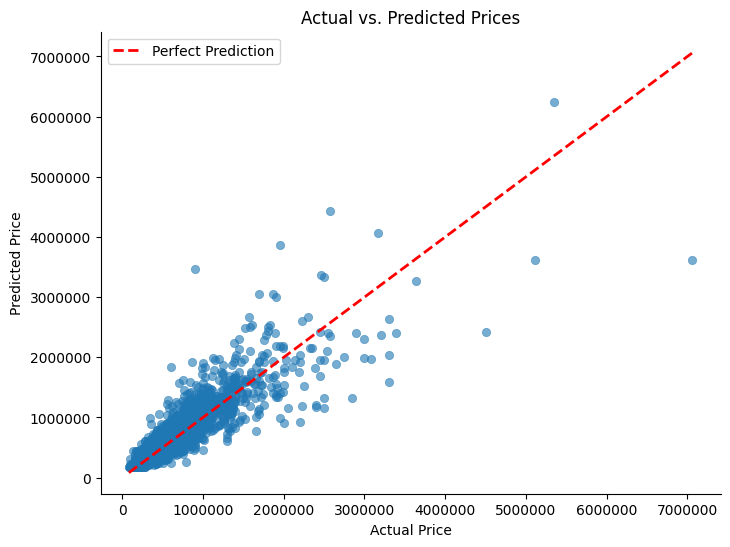

In [31]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pandas['original_price'], y=df_pandas['price_predicted'], alpha=0.6, edgecolor=None)

plt.plot([min(df_pandas['original_price']), max(df_pandas['original_price'])],
         [min(df_pandas['original_price']), max(df_pandas['original_price'])],
         color='red', linestyle='--', linewidth=2, label="Perfect Prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices")

plt.ticklabel_format(style='plain', axis='both')

sns.despine()
plt.legend()
plt.show()


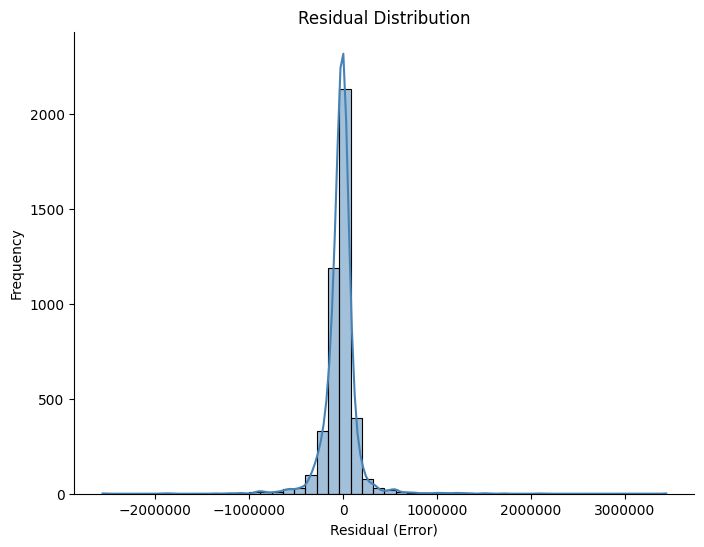

In [32]:
residuals = df_pandas['original_price'] - df_pandas['price_predicted']

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True, color="steelblue")

plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")

plt.ticklabel_format(style='plain', axis='both')

sns.despine()
plt.show()
